# Working with live data

In this tutorial we will explore how to work with live data when using the `gwrefpy` package.

This notebook can be downloaded from the source code [here](https://github.com/andersretznerSGU/gwrefpy/blob/main/docs/tutorials/livedata.ipynb).

We will cover the following topics:
1. Create some synthetic live data
2. Create a model and add wells and fit them
3. Update the wells with new data
4. Track the fit quality over time

## 1. Create some synthetic live data
We start by creating some synthetic data. In a real-world scenario, this data would be read from a database or a file. We will create two sets of data: an initial set and a live set. The initial set will be used to fit the model, and the live set will be used to update the model.

In [1]:
import gwrefpy as gr
import pandas as pd
import numpy as np
gr.set_log_level("ERROR")

ndays_init = 180 # initial data length
ndays_live = 365 # live data length
dates_init = pd.date_range(start="2020-01-01", periods=ndays_init, freq="D") # initial dates
dates_live = pd.date_range(start=dates_init[-1], periods=ndays_live, freq="D") # live dates

# create synthetic data
obs_init = pd.Series(5 + np.sin(np.linspace(0, 4 * np.pi, ndays_init)) + (np.random.normal(0, 0.1, ndays_init) * 2), index=dates_init)
ref_init = pd.Series(10 + np.sin(np.linspace(0, 4 * np.pi, ndays_init)) + np.random.normal(0, 0.1, ndays_init), index=dates_init)
obs_live = pd.Series(5 + np.sin(np.linspace(0, 6 * np.pi, ndays_live)) + (np.random.normal(0, 0.11, ndays_live) * 2), index=dates_live)
# add a drawdown event in the middle of the live data
start = int(ndays_live / 4)
end = int(ndays_live / 2)
half = (end - start) // 2
x = np.concatenate([
    np.linspace(0, 1, half, endpoint=False),
    np.linspace(1, 0, (end - start) - half)
])
obs_live[start:end] -= 1.2 * x**2
ref_live = pd.Series(10 + np.sin(np.linspace(0, 6 * np.pi, ndays_live)) + np.random.normal(0, 0.1, ndays_live), index=dates_live)


## 2. Create a model and add wells
We add the initial data to the wells and create a model.

In [2]:
well_obs = gr.Well(name="Obs well", is_reference=False, timeseries=obs_init)
well_ref = gr.Well(name="Ref well", is_reference=True, timeseries=ref_init)
model = gr.Model(name="Live data model")
model.add_well([well_obs, well_ref])

We can now fit the model to the initial data.

In [3]:
model.fit(well_obs, well_ref, offset="0D")

Statistic,Value,Description
RMSE,0.2242,Root Mean Square Error
R²,0.9144,Coefficient of Determination
R-value,0.9563,Correlation Coefficient
Slope,1.0300,Linear Regression Slope
Intercept,-5.2788,Linear Regression Intercept
P-value,0.0000,Statistical Significance
N,180,Number of Data Points
Std Error,0.2254,Standard Error
Confidence,95.0%,Confidence Level


We now take a look at the fit.

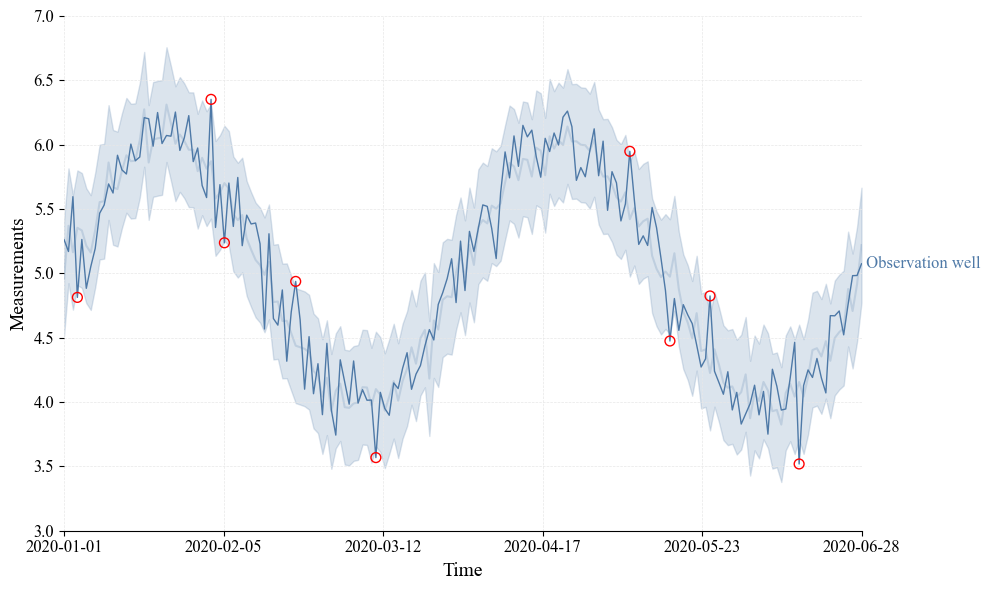

In [4]:
_ = model.plot_fits(plot_style="fancy", color_style="color")

```{tip}
You can use the `plot_fitmethod` method to visualize the fit method.
```

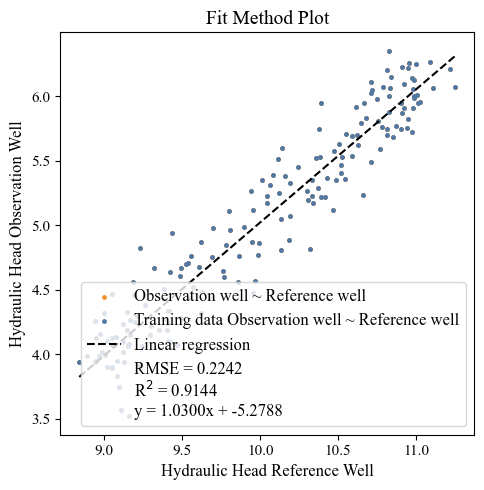

In [5]:
_ = model.plot_fitmethod(plot_style="fancy", color_style="color")

## 3. Update the wells with new data
We can now update the wells with the live data. This is done by appending the new data to the existing timeseries.
```{warning}
If the dates in the new data overlap with the existing data an error will be raised. You can supress this error and remove the duplicates by using `remove_duiplicates=True` argument in the `append_timeseries` method.
```

In [6]:
well_obs.append_timeseries(obs_live, remove_duplicates=True)
well_ref.append_timeseries(ref_live, remove_duplicates=True)

We can now plot the updated data.

```{tip}
You can use the `show_initiation_period` argument to highlight the initial data period.
```

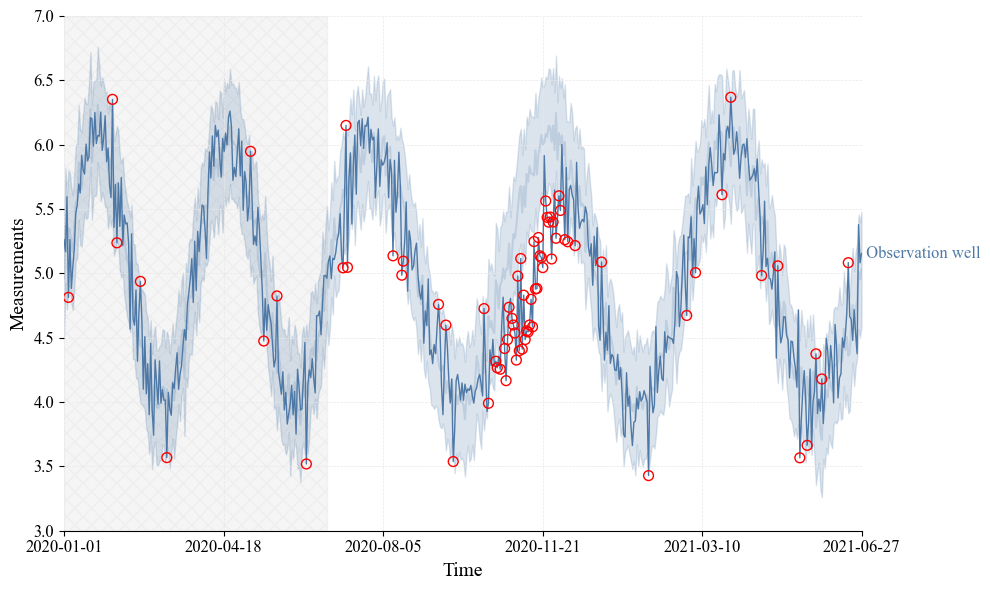

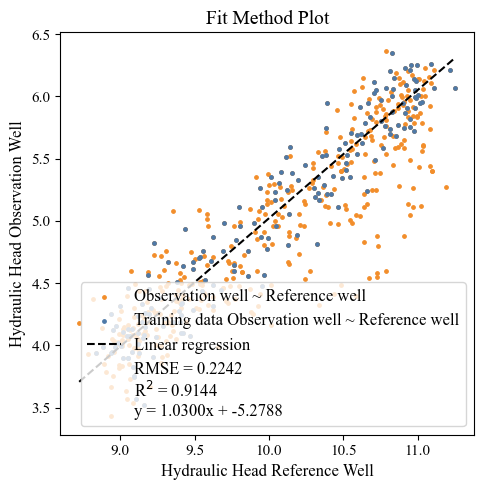

In [7]:
_ = model.plot_fits(plot_style="fancy", color_style="color", show_initiation_period=True)
_ = model.plot_fitmethod(plot_style="fancy", color_style="color")

We can see that in the new data we have a drawdown event that is clearly exceeding the prediction interval.

This concludes this notebook on working with live data. Happy coding!